<a href="https://colab.research.google.com/github/rithikkulkarni/Video-Virality-Testing/blob/main/notebooks/classification_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification
This notebook builds classification models to predict whether a YouTube video will perform well using image and text-based features.


In [56]:
filename = "feature_data.csv"

import pandas as pd

url = f"https://raw.githubusercontent.com/rithikkulkarni/Video-Virality-Testing/refs/heads/main/data/{filename}"
df = pd.read_csv(url)
print(df.head())
print(df.columns)

      avg_red   avg_green    avg_blue  brightness   contrast  title_sentiment  \
0  138.012899  148.504583  101.299410  129.272297  43.861396           0.0000   
1  149.605955  172.237934   98.028958  139.957616  46.774566           0.0000   
2  151.307049  181.823490  105.495087  146.208542  53.358610          -0.1875   
3  154.229896  170.695260  105.417951  143.447703  52.748081          -1.0000   
4  135.671024  140.844722  103.781354  126.765700  47.326907           0.0000   

   title_subjectivity  num_question_marks  num_exclamation_marks  \
0                 0.0                 0.0                    0.0   
1                 0.0                 0.0                    0.0   
2                 0.5                 0.0                    0.0   
3                 1.0                 0.0                    0.0   
4                 0.0                 0.0                    0.0   

   starts_with_keyword  ...  title_readability  is_listicle  is_tutorial  \
0                  0.0  ... 

In [57]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

X = df.drop(columns=['viral'])
y = df['viral']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
print(X.columns)
print()
print(y)

Index(['avg_red', 'avg_green', 'avg_blue', 'brightness', 'contrast',
       'title_sentiment', 'title_subjectivity', 'num_question_marks',
       'num_exclamation_marks', 'starts_with_keyword', 'title_length',
       'word_count', 'punctuation_count', 'uppercase_word_count',
       'percent_letters_uppercase', 'num_digits', 'clickbait_score',
       'num_power_words', 'num_timed_words', 'tag_count', 'tag_sentiment',
       'num_unique_tags', 'clickbait_phrase_match', 'title_readability',
       'is_listicle', 'is_tutorial', 'num_faces', 'dominant_color_hue',
       'thumbnail_edge_density', 'power_word_count', 'timed_word_count',
       'num_tags', 'avg_tag_length'],
      dtype='object')

0      0
1      1
2      0
3      0
4      1
      ..
659    0
660    0
661    0
662    0
663    0
Name: viral, Length: 664, dtype: int64


In [59]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models = {
    "XGBoost": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(
            scale_pos_weight=(sum(y == 0) / sum(y == 1)),
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42))
    ]),
    "SMOTE + Random Forest": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}


🔍 XGBoost – 10-Fold Cross-Validation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:31:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Precision (threshold=0.3): 0.237
Recall (threshold=0.3): 0.365
ROC AUC: 0.675

Classification Report (threshold={new_threshold}):
              precision    recall  f1-score   support

           0      0.915     0.853     0.882       590
           1      0.237     0.365     0.287        74

    accuracy                          0.798       664
   macro avg      0.576     0.609     0.585       664
weighted avg      0.839     0.798     0.816       664



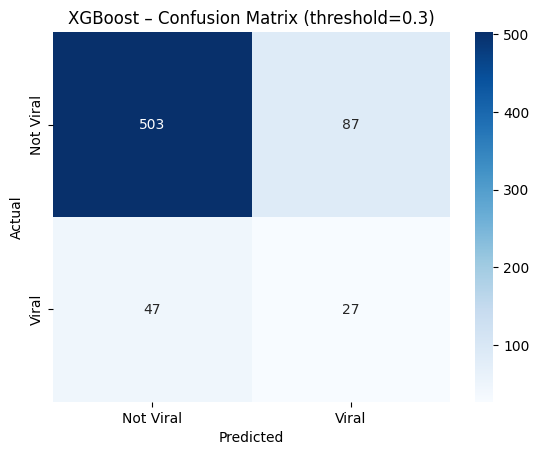

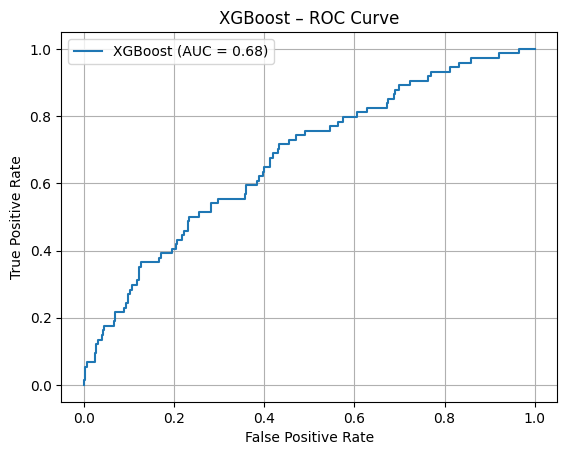

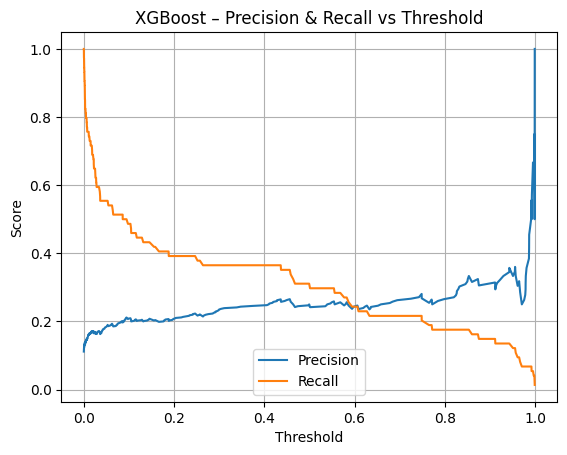


🔍 SMOTE + Random Forest – 10-Fold Cross-Validation
Precision (threshold=0.3): 0.224
Recall (threshold=0.3): 0.554
ROC AUC: 0.676

Classification Report (threshold={new_threshold}):
              precision    recall  f1-score   support

           0      0.931     0.759     0.837       590
           1      0.224     0.554     0.319        74

    accuracy                          0.736       664
   macro avg      0.578     0.657     0.578       664
weighted avg      0.853     0.736     0.779       664



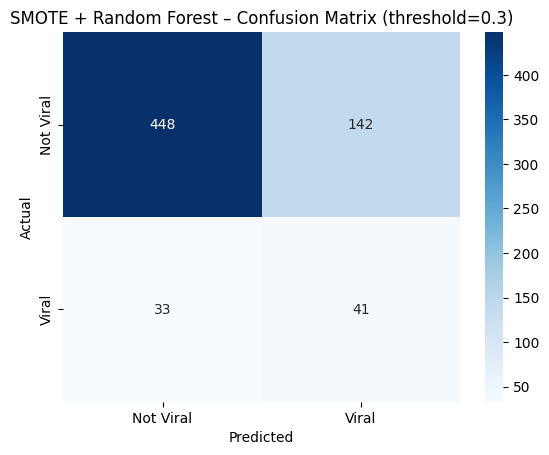

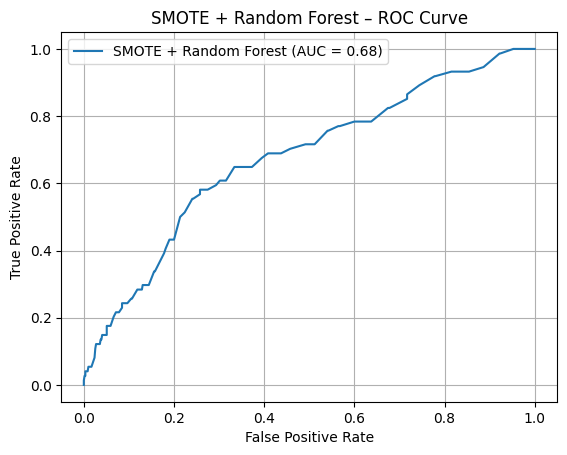

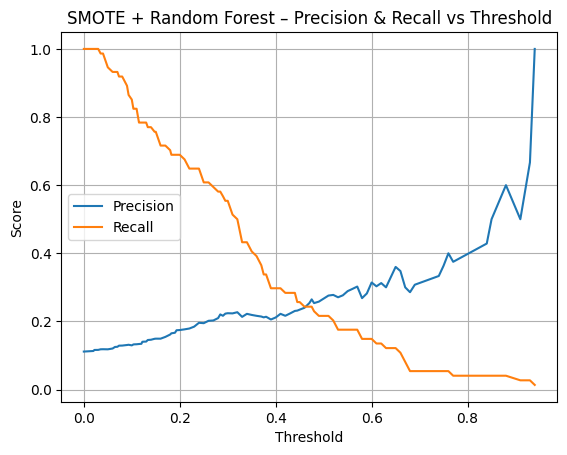

In [63]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

for name, pipeline in models.items():
    print(f"\n🔍 {name} – 10-Fold Cross-Validation")

    # Collect predictions and probabilities via CV
    probs = cross_val_predict(pipeline, X_scaled, y, cv=cv, method='predict_proba')[:, 1]

    # Define your desired threshold (e.g., 0.3 instead of 0.5)
    new_threshold = 0.3

    # Apply the new threshold to get predictions
    preds_at_threshold = (probs >= new_threshold).astype(int)

    # Evaluation metrics using the new predictions
    precision = precision_score(y, preds_at_threshold)
    recall = recall_score(y, preds_at_threshold)
    roc_auc = roc_auc_score(y, probs) # ROC AUC is not affected by threshold

    print(f"Precision (threshold={new_threshold}): {precision:.3f}")
    print(f"Recall (threshold={new_threshold}): {recall:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print("\nClassification Report (threshold={new_threshold}):")
    print(classification_report(y, preds_at_threshold, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y, preds_at_threshold)
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Viral", "Viral"], yticklabels=["Not Viral", "Viral"])
    plt.title(f"{name} – Confusion Matrix (threshold={new_threshold})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve (still use original probabilities)
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.title(f"{name} – ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall vs Threshold Plot (still use original probabilities)
    from sklearn.metrics import precision_recall_curve

    prec, rec, thresholds = precision_recall_curve(y, probs)
    plt.figure()
    plt.plot(thresholds, prec[:-1], label='Precision')
    plt.plot(thresholds, rec[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{name} – Precision & Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()